The code below is adapted from https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html?highlight=equalize.
It aims to show the difference between the original image and applying intensity rescaling or (adaptive) histogram equalization.

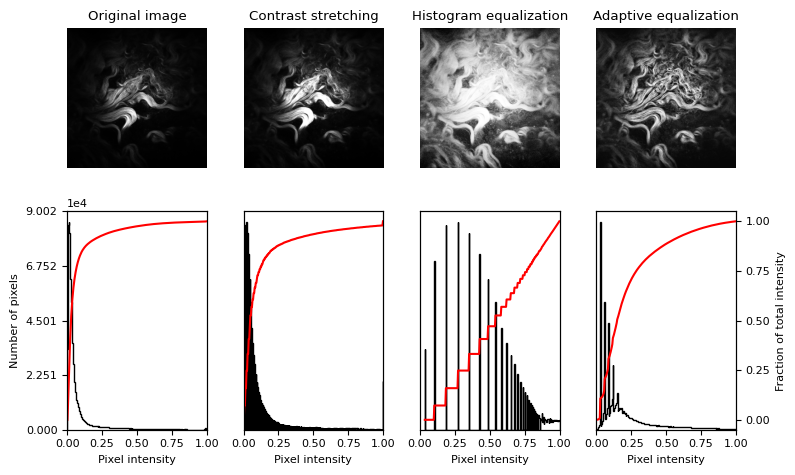

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import img_as_float
from skimage import exposure
from PIL import Image


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img_path = "/scistor/guest/sjg203/projects/shg-strain-stress/data/z-stacks/6/0.bmp"
pil_img = Image.open(img_path)
img_rgb = np.asarray(pil_img)

# Eject 2PEF and THG channels
img = img_rgb[:, :, 0]

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, kernel_size=40, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Original image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [15]:
# To save images to see difference elsewhere.
# img_o = Image.fromarray(img)
# img_o.save("outputs/histogram-equalization/6-0-o.png")
# img_ahe = Image.fromarray((img_adapteq * 255).astype(np.uint8))
# img_ahe.save("outputs/histogram-equalization/6-0-ahe.png")


In [35]:
# To save images trying different adaptive kernels.
# for kernel in np.arange(10, 50, 20):
#     img_temp = exposure.equalize_adapthist(img, kernel_size=kernel, clip_limit=0.03)
#     img_ahe = Image.fromarray((img_temp * 255).astype(np.uint8))
#     img_ahe.save(f"outputs/histogram-equalization/6-0-ahe-{kernel}.png")

In [75]:
def equalize_all(image_paths: list[str], output_path: str) -> None:
    """Equalizes all images selected with a list of image paths using CLAHE.
    
    The output path must not contain a trailing "/".
    """
    from tqdm import tqdm
    import os

    stack_id_of_non_color_imgs = []

    for path in tqdm(image_paths):
        stack_id = path.split('/')[-2]
        slice_fn = path.split('/')[-1]

        # Read image from file
        img_pil = Image.open(path)
        img_rgb = np.asarray(img_pil)

        # Eject 2PEF and THG channels
        try:
            img = img_rgb[:, :, 0]
        except IndexError:
            # Sometimes, images are not stored with 3 channels.
            # Take note of these images.
            if stack_id not in stack_id_of_non_color_imgs:
                stack_id_of_non_color_imgs.append(stack_id)
                tqdm.write(f"{stack_id} does not contain color information.")
            img = img_rgb

        img_ahe = exposure.equalize_adapthist(img, kernel_size=100, clip_limit=0.03)

        img_ahe_pil = Image.fromarray((img_ahe * 255).astype(np.uint8))

        if not os.path.exists(f"{output_path}/{stack_id}"):
            os.makedirs(f"{output_path}/{stack_id}")

        img_ahe_pil.save(f"{output_path}/{stack_id}/{slice_fn}")


In [76]:
from glob import glob

In [77]:
# Running this cell means you have to wait a while :)
# It discovers images, applies adaptive histogram equalization on all of them and store them in a subdirectory.

image_paths = glob(f"../data/z-stacks/**/*.bmp")
output_path = "../data/preprocessed/z-stacks"

In [78]:
equalize_all(image_paths, output_path)

  2%|▏         | 31/1905 [00:03<03:03, 10.21it/s]

9 does not contain color information.


 68%|██████▊   | 1291/1905 [02:06<00:58, 10.50it/s]

8 does not contain color information.


 76%|███████▌  | 1445/1905 [02:21<00:44, 10.39it/s]

34 does not contain color information.


100%|██████████| 1905/1905 [03:04<00:00, 10.30it/s]
